## Arquivo para tratar classe de modificacao de patch

In [1]:
import torch
import torch.nn as nn
from transformers import ViTForImageClassification, ViTModel, ViTConfig
import pytorch_lightning as pl
import random
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torchvision import transforms

d:\AREA_DE_TRABALHO\Faculdade_7_Periodo\TCC1\VIT-cric\vit-dynamic-patches\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Patch padrão

In [56]:
import torch
import torch.nn as nn
from transformers import ViTForImageClassification, ViTConfig
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torchvision import transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class CustomViTForImageClassification(ViTForImageClassification):
    def __init__(self, config, custom_patch_processing=None):
        super().__init__(config)
        self.custom_patch_processing = custom_patch_processing

    def forward(self, pixel_values):
        # Extract patches (tokens) from images
        batch_size, num_channels, height, width = pixel_values.shape
        patch_size = self.config.patch_size

        num_patches = (height // patch_size) * (width // patch_size)
        patch_dim = num_channels * patch_size * patch_size

        patches = pixel_values.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
        patches = patches.permute(0, 2, 3, 1, 4, 5).reshape(batch_size, num_patches, patch_dim)

        if self.custom_patch_processing:
            patches, selected_indices = self.custom_patch_processing(patches, patch_size)
            return patches, selected_indices

        # Forward pass through ViT model
        embedding_output = self.vit.embeddings(inputs_embeds=patches)

        return embedding_output

class Modelo(pl.LightningModule):
    def __init__(self, num_class, learning_rate, custom_patch_processing=None):
        super(Modelo, self).__init__()
        
        self.num_class = num_class
        self.learning_rate = learning_rate
        
        config = ViTConfig.from_pretrained('google/vit-base-patch16-224')
        config.num_labels = self.num_class

        self.model = CustomViTForImageClassification(config, custom_patch_processing)
        self.model.to(device)
        print("----------------------------------------------------------------")
        for param in self.model.parameters():
            param.requires_grad = False
            
        for param in self.model.classifier.parameters():
            param.requires_grad = True
            
        self.model.classifier = nn.Sequential(
            nn.Linear(self.model.config.hidden_size, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, self.num_class)
        )

        self.criterion = nn.CrossEntropyLoss()
        print(self.model)
        print("----------------------------------------------------------------")
   
    def forward(self, x):
        logits = self.model(x).logits
        return logits

    def training_step(self, batch, batch_idx):
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        logits = self(images)
        loss = self.criterion(logits, labels)
        _, predicted = torch.max(logits, 1)
        accuracy = (predicted == labels).float().mean()
                
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_accuracy', accuracy, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        logits = self(images)
        loss = self.criterion(logits, labels)
        _, predicted = torch.max(logits, 1)
        accuracy = (predicted == labels).float().mean()
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_accuracy', accuracy, on_epoch=True, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

# Função para desenhar patches na imagem
def plot_image_with_patches(image, patch_size, selected_indices):
    fig, ax = plt.subplots()
    ax.imshow(image.permute(1, 2, 0).cpu().numpy())

    for idx in selected_indices:
        row = (idx // (image.shape[2] // patch_size))
        col = (idx % (image.shape[2] // patch_size))
        rect = plt.Rectangle((col * patch_size, row * patch_size), patch_size, patch_size, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()

# Função para carregar e transformar uma imagem
def load_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    image = Image.open(image_path).convert("RGB")
    image = transform(image)
    return image.unsqueeze(0)  # Adicionar dimensão do batch

# Função de processamento de patch tradicional
def traditional_patch_processing(patches, patch_size):
    batch_size, num_patches, patch_dim = patches.shape
    selected_indices = list(range(num_patches))
    return patches, selected_indices


----------------------------------------------------------------
CustomViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (in

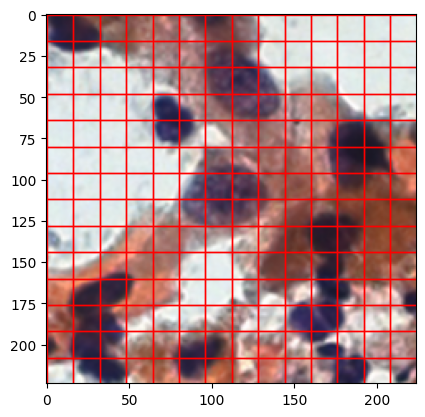

In [57]:
# Exemplo de uso
num_classes = 10
learning_rate = 0.001
model = Modelo(num_classes, learning_rate, custom_patch_processing=traditional_patch_processing)

# Carregar uma imagem de um caminho
image_path = '../data/base_recortada/ASC-H/10.png'
image = load_image(image_path).to(device)

# Passar a imagem pelo modelo para obter patches e índices selecionados
patches, selected_indices_batch = model.model(image)
selected_indices = selected_indices_batch[0] if isinstance(selected_indices_batch[0], list) else selected_indices_batch  # Garantir que os índices sejam uma lista

# Plotar a imagem com os patches destacados
plot_image_with_patches(image[0], model.model.config.patch_size, selected_indices)

In [50]:
from transformers import ViTForImageClassification

# Carregar o modelo pré-treinado
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

# Tamanho da imagem e tamanho do patch
image_size = model.config.image_size
patch_size = model.config.patch_size

# Calcular o número de patches
num_patches = (image_size // patch_size) ** 2

print(f"Number of patches: {num_patches}")
print(f"Image size: {image_size}")
print(f"Patch size: {patch_size}")

Number of patches: 196
Image size: 224
Patch size: 16


### Patch modificado